In [5]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import time

In [6]:
#Loading the folded datasets
train = np.load('Fold1_echo_img_train.npy')
valid = np.load('Fold1_echo_img_valid.npy')
test = np.load('Fold1_echo_img_test.npy')

In [7]:
#Loading the folded datasets
train_lab = np.load('Fold1_echo_msk_train.npy')
valid_lab = np.load('Fold1_echo_msk_valid.npy')
test_lab = np.load('Fold1_echo_msk_test.npy')

In [8]:
size = train.shape[2] #getting the size of the image

#Splitting the data from labels
x_train = train.transpose(0,3,1,2).astype('float32')#formatting shape from (n,height,width,channel) to (n,channel,height,width)
y_train = train_lab.reshape(-1,1,size,size).astype('float32')#reshaping the labels to include a channel

x_valid = valid.transpose(0,3,1,2).astype('float32')
y_valid = valid_lab.reshape(-1,1,size,size).astype('float32')

x_test = test.transpose(0,3,1,2).astype('float32')
y_test = test_lab.reshape(-1,1,size,size).astype('float32')

In [9]:
#Converting the numpy arrays to tensors
train_lab = torch.tensor(y_train)
train_data = torch.tensor(x_train)
train_data = train_data.float()
train_lab = train_lab.long()

valid_lab = torch.tensor(y_valid)
valid_data = torch.tensor(x_valid)
valid_data = valid_data.float()
valid_lab = valid_lab.long()

test_lab = torch.tensor(y_test)
test_data = torch.tensor(x_test)
test_data = test_data.float()
test_lab = test_lab.long()

In [10]:
#Wrapping models and loaders to gpu
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
#Combining the formatted data and labels
training = []
validation = []
testing = []

for i in range(len(x_train)):
    training.append([train_data[i],train_lab[i]])
    
for i in range(len(x_valid)):
    validation.append([valid_data[i],valid_lab[i]])
    
for i in range(len(x_test)):
    testing.append([test_data[i],test_lab[i]])

In [12]:
#Storing to data loaders
train_loader = DataLoader(training, batch_size=20, shuffle=True)
valid_loader = DataLoader(validation, batch_size=10, shuffle=False)
test_dl = DataLoader(testing, batch_size=10, shuffle=False)

In [13]:
#Transferring to GPU
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(valid_loader, device)
test_dl = DeviceDataLoader(test_dl, device)

In [14]:
#ENCODER = 'timm-resnest50d' #resnet
ENCODER_WEIGHTS = 'imagenet' #imagenet weights
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    #encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

In [17]:
#loss to be used
loss = smp.utils.losses.DiceLoss()
#metrics loaded e.g. Accuracy, IoU, Recall
metrics = [
    smp.utils.metrics.Accuracy(),smp.utils.metrics.Fscore(),
    smp.utils.metrics.Precision(),smp.utils.metrics.Recall()
]
#Adam optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [18]:
#library training and validation runs
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 100

total = 0 #total time
t_loss = [] #loss per epoch
v_loss = [] #loss per epoch

for i in range(25):
    
    print('\nEpoch: {}'.format(i))
    
    t_start = time.time()
    train_logs = train_epoch.run(train_dl)
    t_end = time.time()
    train_time = t_end-t_start
    print('Training Time: ',train_time)
    
    t_loss.append((i,train_logs['dice_loss'],train_logs['accuracy']))
    
    v_start = time.time()
    valid_logs = valid_epoch.run(valid_dl)
    v_end = time.time()
    valid_time = v_end-v_start
    print('Validation Time: ',valid_time)
    
    v_loss.append((i,valid_logs['dice_loss'],valid_logs['accuracy']))
    
    total = total + train_time + valid_time
    
    # save the best model
    if max_score > valid_logs['dice_loss']:
        max_score = valid_logs['dice_loss']
        torch.save(model, './best_model.pth')
        print(valid_logs)
        print('Model saved!')
        
print('Total time: ',total)


Epoch: 0
train: 100%|█| 95/95 [02:57<00:00,  1.87s/it, dice_loss - 0.4314, accuracy - 0.9536, fscore - 0.7948, precision - 0.723
Training Time:  177.9385325908661
valid: 100%|█| 23/23 [00:08<00:00,  2.81it/s, dice_loss - 0.1185, accuracy - 0.9933, fscore - 0.9204, precision - 0.914
Validation Time:  8.195617198944092
{'dice_loss': 0.11854384774747101, 'accuracy': 0.9933231084243112, 'fscore': 0.9204224633133932, 'precision': 0.914391312910163, 'recall': 0.9289642987043962}
Model saved!

Epoch: 1
train:  66%|▋| 63/95 [01:51<00:58,  1.83s/it, dice_loss - 0.08318, accuracy - 0.9948, fscore - 0.9371, precision - 0.93

In [14]:
t_loss = np.array(t_loss)
v_loss = np.array(v_loss)

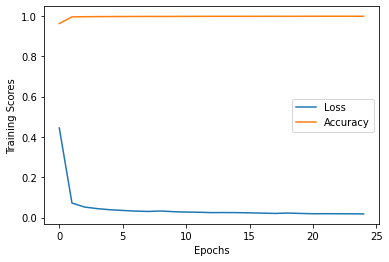

In [15]:
#plotting training scores
plt.plot(t_loss[:,0],t_loss[:,1],label='Loss')
plt.plot(t_loss[:,0],t_loss[:,2],label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Scores')
plt.legend()
plt.show()

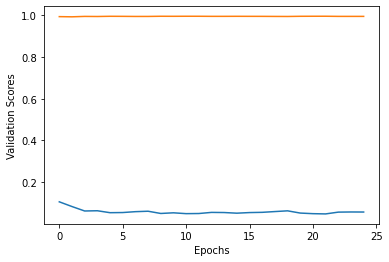

In [16]:
#plotting validation scores
plt.plot(v_loss[:,0],v_loss[:,1],label='Loss')
plt.plot(v_loss[:,0],v_loss[:,2],label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Scores')
plt.show()

In [17]:
#loading the best model
best_model = torch.load('./best_model.pth')

In [18]:
#testing set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

start = time.time()
logs = test_epoch.run(test_dl)
end = time.time()
print('Testing Time: ',end-start)

valid: 100%|█| 24/24 [00:01<00:00, 18.11it/s, dice_loss - 0.06248, accuracy - 0.9948, fscore - 0.9378, precision - 0.91
Testing Time:  1.3270001411437988


In [19]:
logs

{'dice_loss': 0.06248119721810023,
 'accuracy': 0.9947713588674862,
 'fscore': 0.9377796923120815,
 'precision': 0.9112864658236504,
 'recall': 0.9678440416852634,
 'specificity': 0.9960631380478541}

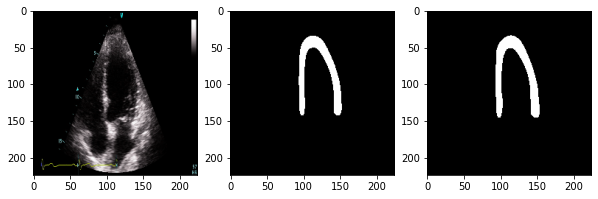

In [20]:
image, gt_mask = testing[0]
    
gt_mask = gt_mask.squeeze()
    
x_tensor = image.cuda().unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,10))
ax1.imshow(image.numpy().transpose(1,2,0).astype('uint8'))
ax2.imshow(gt_mask,cmap='gray')
ax3.imshow(pr_mask,cmap='gray')
plt.show()

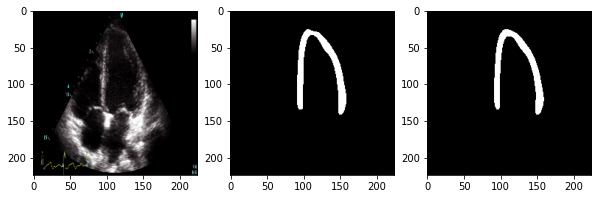

In [21]:
image, gt_mask = testing[30]
    
gt_mask = gt_mask.squeeze()
    
x_tensor = image.cuda().unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,10))
ax1.imshow(image.numpy().transpose(1,2,0).astype('uint8'))
ax2.imshow(gt_mask,cmap='gray')
ax3.imshow(pr_mask,cmap='gray')
plt.show()

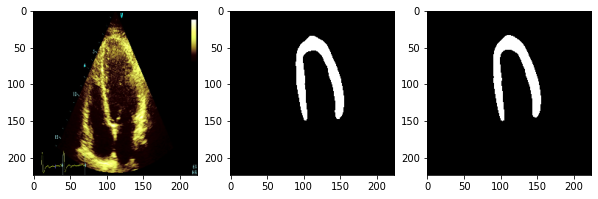

In [22]:
image, gt_mask = testing[60]
    
gt_mask = gt_mask.squeeze()
    
x_tensor = image.cuda().unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,10))
ax1.imshow(image.numpy().transpose(1,2,0).astype('uint8'))
ax2.imshow(gt_mask,cmap='gray')
ax3.imshow(pr_mask,cmap='gray')
plt.show()

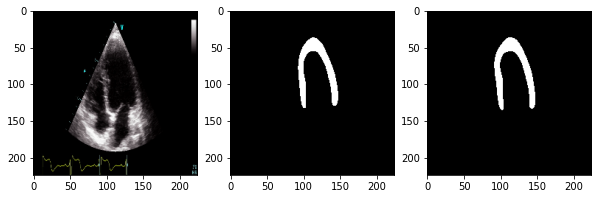

In [23]:
image, gt_mask = testing[90]
    
gt_mask = gt_mask.squeeze()
    
x_tensor = image.cuda().unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,10))
ax1.imshow(image.numpy().transpose(1,2,0).astype('uint8'))
ax2.imshow(gt_mask,cmap='gray')
ax3.imshow(pr_mask,cmap='gray')
plt.show()

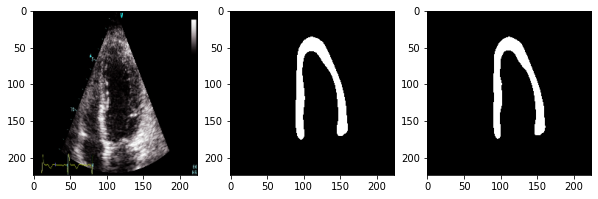

In [24]:
image, gt_mask = testing[120]
    
gt_mask = gt_mask.squeeze()
    
x_tensor = image.cuda().unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,10))
ax1.imshow(image.numpy().transpose(1,2,0).astype('uint8'))
ax2.imshow(gt_mask,cmap='gray')
ax3.imshow(pr_mask,cmap='gray')
plt.show()